# DataThink 2024

**Table of Contents**: <p>
- I. Data and Libraries Import<br>
- II. Data Exploration<br>
- III. Data Cleaning<br>
- IV. Owner Demographics Predictions<br>
- V. Accreditation Status Predictions<br>

# I. Data and Libraries Import

In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as geo
import random
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report, mean_squared_error, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import sklearn
import pickle

In [3]:
# Option setting
pd.set_option('display.max_columns', None)

In [4]:
# Import all necessary datasets
df_MainBusinessData_full = pd.read_csv('MainBusinessData.csv')
df_Demographic = pd.read_csv("DemographicInfo.csv")
df_Government = pd.read_csv("GovernmentAction.csv")
df_DNS = pd.read_csv("DoNotSolicit.csv")
df_OutOfBusiness = pd.read_csv("OutOfBusiness.csv")
df_ACS_HHI = pd.read_csv("AcsCensusData.csv")
df_ACS_Demographic = pd.read_csv("ACS_Demographic.csv")

In [5]:
np.random.seed(42)

# II. Data Exploration

In [145]:
num_rows, num_cols = df_MainBusinessData_full.shape
print(f"The DataFrame has {num_rows} rows and {num_cols} columns.")

The DataFrame has 150887 rows and 20 columns.


In [146]:
def explore_data(df_MainBusinessData_full):
    print("------------------------first 5 rows---------------------------------------------")
    print(df_MainBusinessData_full.head())
    print("------------------------datatype info---------------------------------------------")
    print(df_MainBusinessData_full.info())
    print("------------------------statistics describe---------------------------------------------")
    print(df_MainBusinessData_full.describe())
    print("------------------------sum of missing values in each column---------------------------------------------")
    print(df_MainBusinessData_full.isna().sum())
explore_data(df_MainBusinessData_full)

------------------------first 5 rows---------------------------------------------
   Business ID                                       Business    AB?  \
0     28177632          "big Moma's" General Contractors Inc.  False   
1     27215708                           "Gary"  Wei Chew Tan  False   
2     28116480  "His Will" Hauling And Cleanout Services, LLC  False   
3     27431145                       "R" US Credit Card/gecrb  False   
4     28150857                 "Twins Castillo Flooring", INC  False   

  Established State Established                            TOB  \
0         NaN                GA             General Contractor   
1         NaN                GA               Rentals by Owner   
2  04/30/2017                GA                   Junk Removal   
3         NaN                GA  Credit Card Merchant Services   
4         NaN                GA           Flooring Contractors   

               Address Address 2           City State    Zip Country  \
0     160 Kari G

# III. Data Cleaning

## 1. Cleaning Main Business Dataset

In [147]:
# Filter to keep only records of businesses in GA
df_MainBusinessData_full = df_MainBusinessData_full[df_MainBusinessData_full['State Established'] == 'GA']

# Filter out accredited businesses
Accredited=df_MainBusinessData_full[df_MainBusinessData_full['AB?']==True]

# Filter our unaccredited businesses
Not_Accredited=df_MainBusinessData_full[df_MainBusinessData_full['AB?']==False]
# Disregard business with dns label
Not_Accredited = Not_Accredited[~Not_Accredited['Business ID'].isin(df_DNS['Business ID'])]
# To get accredited, business need to maintain B or higher 
Not_Accredited = Not_Accredited[Not_Accredited['Rating'].isin(['B','B+','A-','A','A+'])]
# Change time format of established column
Not_Accredited['Established']=pd.to_datetime(Not_Accredited['Established'])
# To get accredited, business need to be at least 6 months, using April 1st as the benchmark date
Not_Accredited = Not_Accredited[Not_Accredited['Established'] < '2023-10-01']

# Concat the two dataframes together to create the all cleaned data
All_cleaned=pd.concat([Accredited, Not_Accredited], axis=0, ignore_index=True)

# Export into CSV file
All_cleaned.to_csv('All_cleaned.csv')

## 2. Collecting and Cleaning Census Household Income Data

In [148]:
# Drop index and columns that are unrelated to what we want
df_ACS_HHI = df_ACS_HHI.drop(df_ACS_HHI.index[0])
df_ACS_HHI = df_ACS_HHI.drop(df_ACS_HHI.columns[0], axis = 1)
df_ACS_HHI = df_ACS_HHI.drop(df_ACS_HHI.columns[2:24], axis = 1)

# Rename columns to identify values we want to explore
df_ACS_HHI = df_ACS_HHI.rename(columns={'NAME': 'Zip', 'DP03_0051E': 'Median HHI', 'DP03_0062M': 'Median HHI MoE', 'DP03_0063E': 'Mean HHI', 'DP03_0063M': 'Mean HHI MoE'})

# Rename the values in the 'Zip' column so that it only contains the actual Zip number
df_ACS_HHI.iloc[:, 0] = df_ACS_HHI.iloc[:, 0].astype(str)
df_ACS_HHI.iloc[:, 0] = df_ACS_HHI.iloc[:, 0].apply(lambda x: x[6:])

# Export to CSV
df_ACS_HHI.to_csv("ACS_HHI.csv", index=False)

## 3. Collecting and Cleaning Census Demographic Data

In [149]:
# Remove the column with the exact population and keep the column with the percentage of population
df_ACS_Demographic = df_ACS_Demographic.loc[:, ~df_ACS_Demographic.columns.duplicated(keep='last')]

# Set the first row as column names
df_ACS_Demographic.rows = df_ACS_Demographic.iloc[0]

# Drop the first row after using it as column names
df_ACS_Demographic = df_ACS_Demographic.drop(df_ACS_Demographic.index[0])

df_ACS_Demographic

/var/folders/w4/_qkz1qq54vb56zbst46rjs740000gn/T/ipykernel_2849/2484090512.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_ACS_Demographic.rows = df_ACS_Demographic.iloc[0]


Race ZCTA5 30002!!Estimate  \
1            Hispanic or Latino (of any race)                    84   
2                                       White                 3,535   
3                   Black or African American                 1,763   
4           American Indian and Alaska Native                     0   
5                                       Asian                   157   
6  Native Hawaiian and Other Pacific Islander                    13   
7                             Some Other Race                    35   
8                           Two or More Races                   269   

  ZCTA5 30002!!Percent ZCTA5 30004!!Estimate ZCTA5 30004!!Percent  \
1                1.40%                 7,303               11.00%   
2               60.40%                36,731               55.30%   
3               30.10%                 7,070               10.60%   
4                0.00%                     0                0.00%   
5                2.70%                12,405               18.70%   
6                0.20%                     0                0.00%   
7                0.60%                   217                0.30%   
8                4.60%                 2,680                4.00%   

  ZCTA5 30005!!Estimate ZCTA5 30005!!Percent ZCTA5 30008!!Estimate  \
1                 2,719                6.80%                10,616   
2                20,968               52.10%                 6,947   
3                 4,715               11.70%                14,567   
4                    21                0.10%                    10   
5                10,449               26.00%                 1,019   
6                     0                0.00%                     5   
7                   344                0.90%                   275   
8                 1,044                2.60%                   892   

  ZCTA5 30008!!Percent ZCTA5 30009!!Estimate ZCTA5 30009!!Percent  \
1               30.90%                 1,508                7.10%   
2               20.20%                13,402               63.00%   
3               42.40%                 2,041                9.60%   
4                0.00%                     5                0.00%   
5                3.00%                 2,902               13.60%   
6                0.00%                     7                0.00%   
7                0.80%                   743                3.50%   
8                2.60%                   673                3.20%   

  ZCTA5 30011!!Estimate ZCTA5 30011!!Percent ZCTA5 30012!!Estimate  \
1                 3,178               15.10%                 5,949   
2                11,597               55.30%                 9,523   
3                 4,562               21.70%                16,600   
4                    54                0.30%                     0   
5                   821                3.90%                   376   
6                     0                0.00%                     0   
7                     0                0.00%                   171   
8                   766                3.70%                   826   

  ZCTA5 30012!!Percent ZCTA5 30013!!Estimate ZCTA5 30013!!Percent  \
1               17.80%                 2,029                7.90%   
2               28.50%                 4,760               18.40%   
3               49.60%                16,981               65.80%   
4                0.00%                    68                0.30%   
5                1.10%                   870                3.40%   
6                0.00%                   277                1.10%   
7                0.50%                   261                1.00%   
8                2.50%                   566                2.20%   

  ZCTA5 30014!!Estimate ZCTA5 30014!!Percent ZCTA5 30016!!Estimate  \
1                 3,631                8.90%                 2,625   
2                22,591               55.20%                18,002   
3                13,159               32.20%                35,

In [150]:
# Define function to extract text before a marker
def before_first(text, marker):
    last_exclamation_index = text.rfind("!")
    # Check if "!" is found in the string
    if last_exclamation_index != -1:
        # Return the text after the last "!"
        return text[:last_exclamation_index-1].strip()
    else:
        # If "!" is not found, return the original string
        return text

# Rename the column names to the actual Zip code
df_ACS_Demographic.rename(columns=lambda x: before_first(x[5:], "!"), inplace=True)
df_ACS_Demographic.set_index('', inplace=True)

# Remove the column with the actual population while keeping the column with percentage population
df_ACS_Demographic = df_ACS_Demographic.loc[:, ~df_ACS_Demographic.columns.duplicated(keep='last')]

# Transpose the table so that each Zip code is on a separate row
df_ACS_Demographic = df_ACS_Demographic.transpose()

In [151]:
# Define function to extract number before percentage sign
def before_first(text, marker):
    if isinstance(text, str):
        last_exclamation_index = text.find(marker)
        if last_exclamation_index != -1:
            return text[:last_exclamation_index].strip()
    return text

# Apply the function to the population percentages to remove percentage sign
df_ACS_Demographic = df_ACS_Demographic.applymap(lambda x: before_first(x, "%"))

# Remove empty rows in the 'White' column
df_ACS_Demographic = df_ACS_Demographic[df_ACS_Demographic['White'] != '-']

/var/folders/w4/_qkz1qq54vb56zbst46rjs740000gn/T/ipykernel_2849/1107084819.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_ACS_Demographic = df_ACS_Demographic.applymap(lambda x: before_first(x, "%"))


In [152]:
# Modify all datatypes to be 'float'
df_ACS_Demographic = df_ACS_Demographic.astype('float')

# Rename the index column to be 'Zip'
df_ACS_Demographic = df_ACS_Demographic.rename_axis('Zip')

# Rename the column for conciseness
df_ACS_Demographic = df_ACS_Demographic.rename(columns={'Hispanic or Latino (of any race)': 'Hispanic or Latino'})

In [153]:
# Convert all percentages from scale of 100 to scale of 1
df_ACS_Demographic['Hispanic or Latino'] = df_ACS_Demographic['Hispanic or Latino'] / 100
df_ACS_Demographic['White'] = df_ACS_Demographic['White'] / 100
df_ACS_Demographic['Black or African American'] = df_ACS_Demographic['Black or African American'] / 100
df_ACS_Demographic['American Indian and Alaska Native'] = df_ACS_Demographic['American Indian and Alaska Native'] / 100
df_ACS_Demographic['Asian'] = df_ACS_Demographic['Asian'] / 100
df_ACS_Demographic['Native Hawaiian and Other Pacific Islander'] = df_ACS_Demographic['Native Hawaiian and Other Pacific Islander'] / 100
df_ACS_Demographic['Some Other Race'] = df_ACS_Demographic['Some Other Race'] / 100
df_ACS_Demographic['Two or More Races'] = df_ACS_Demographic['Two or More Races'] / 100

In [154]:
df_ACS_Demographic

Hispanic or Latino  White  Black or African American  \
Zip                                                           
30002               0.014  0.604                      0.301   
30004               0.110  0.553                      0.106   
30005               0.068  0.521                      0.117   
30008               0.309  0.202                      0.424   
30009               0.071  0.630                      0.096   
...                   ...    ...                        ...   
39870               0.013  0.501                      0.373   
39877               0.000  0.609                      0.389   
39885               0.000  0.211                      0.789   
39886               0.021  0.406                      0.525   
39897               0.088  0.712                      0.181   

       American Indian and Alaska Native  Asian  \
Zip                                               
30002                              0.000  0.027   
30004                              0.000  0.187   
30005                              0.001  0.260   
30008                              0.000  0.030   
30009                              0.000  0.136   
...                                  ...    ...   
39870                              0.003  0.066   
39877                              0.000  0.000   
39885                              0.000  0.000   
39886                              0.000  0.000   
39897                              0.006  0.004   

       Native Hawaiian and Other Pacific Islander  Some Other Race  \
Zip                                                                  
30002                                       0.002            0.006   
30004                                       0.000            0.003   
30005                                       0.000            0.009   
30008                                       0.000            0.008   
30009                                       0.000            0.035   
...                                           ...              ...   
39870                                       0.000            0.000   
39877                                       0.000            0.000   
39885                                       0.000            0.000   
39886                                       0.000            0.008   
39897                                       0.000            0.000   

       Two or More Races  
Zip                       
30002              0.046  
30004              0.040  
30005              0.026  
30008              0.026  
30009              0.032  
...                  ...  
39870              0.043  
39877              0.002  
39885              0.000  
39886              0.040  
39897              0.009  

[735 rows x 8 columns]

In [155]:
df_ACS_Demographic.to_csv('demographic_composition.csv', index=True)

In [156]:
df_MainBusinessData_clean = pd.read_csv('All_cleaned.csv')
df_HHI = pd.read_csv("ACS_HHI.csv")
df_demographic_composition = pd.read_csv("demographic_composition.csv")

# IV. Owner Demographic Predictions

## 1. Demographic Predictions using Census Data

In this section, I am attempting to assign a demographic to companies with no demographic information based on the demographic composition of the zip code where the company is. The assumption is that small business owners tend to have the businesses close to where they live and thus we can assume the demographic of the business owner through the demographic of the Zip code where the business is based.

In [157]:
# View the Demographic Composition Dataframe
df_demographic_composition

Zip  Hispanic or Latino  White  Black or African American  \
0    30002               0.014  0.604                      0.301   
1    30004               0.110  0.553                      0.106   
2    30005               0.068  0.521                      0.117   
3    30008               0.309  0.202                      0.424   
4    30009               0.071  0.630                      0.096   
..     ...                 ...    ...                        ...   
730  39870               0.013  0.501                      0.373   
731  39877               0.000  0.609                      0.389   
732  39885               0.000  0.211                      0.789   
733  39886               0.021  0.406                      0.525   
734  39897               0.088  0.712                      0.181   

     American Indian and Alaska Native  Asian  \
0                                0.000  0.027   
1                                0.000  0.187   
2                                0.001  0.260   
3                                0.000  0.030   
4                                0.000  0.136   
..                                 ...    ...   
730                              0.003  0.066   
731                              0.000  0.000   
732                              0.000  0.000   
733                              0.000  0.000   
734                              0.006  0.004   

     Native Hawaiian and Other Pacific Islander  Some Other Race  \
0                                         0.002            0.006   
1                                         0.000            0.003   
2                                         0.000            0.009   
3                                         0.000            0.008   
4                                         0.000            0.035   
..                                          ...              ...   
730                                       0.000            0.000   
731                                       0.000            0.000   
732                                       0.000            0.000   
733                                       0.000            0.008   
734                                       0.000            0.000   

     Two or More Races  
0                0.046  
1                0.040  
2                0.026  
3                0.026  
4                0.032  
..                 ...  
730              0.043  
731              0.002  
732              0.000  
733              0.040  
734              0.009  

[735 rows x 9 columns]

In [158]:
# Extract the column names into a list of demographics
demographic_list = df_demographic_composition.columns.tolist()
# Remove 'Zip' from the list
demographic_list.pop(0)

# Extract the values into a list of Zip code and accompanying probability for each demographic
probability_list = df_demographic_composition.values.tolist()
probability_list

[[30002.0, 0.0139999999999999, 0.604, 0.301, 0.0, 0.027, 0.002, 0.006, 0.046],
 [30004.0, 0.11, 0.5529999999999999, 0.106, 0.0, 0.187, 0.0, 0.003, 0.04],
 [30005.0, 0.068, 0.521, 0.1169999999999999, 0.001, 0.26, 0.0, 0.009, 0.026],
 [30008.0, 0.309, 0.2019999999999999, 0.424, 0.0, 0.03, 0.0, 0.008, 0.026],
 [30009.0, 0.071, 0.63, 0.096, 0.0, 0.136, 0.0, 0.035, 0.032],
 [30011.0, 0.151, 0.5529999999999999, 0.217, 0.003, 0.039, 0.0, 0.0, 0.037],
 [30012.0, 0.178, 0.285, 0.496, 0.0, 0.011, 0.0, 0.005, 0.025],
 [30013.0, 0.079, 0.184, 0.6579999999999999, 0.003, 0.034, 0.011, 0.01, 0.022],
 [30014.0, 0.089, 0.552, 0.322, 0.001, 0.009, 0.0, 0.001, 0.026],
 [30016.0, 0.044, 0.304, 0.595, 0.002, 0.015, 0.0, 0.001, 0.038],
 [30017.0, 0.121, 0.335, 0.473, 0.0, 0.025, 0.0, 0.006, 0.04],
 [30018.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [30019.0,
  0.111,
  0.5539999999999999,
  0.221,
  0.001,
  0.069,
  0.0,
  0.0069999999999999,
  0.037],
 [30021.0, 0.037, 0.123, 0.607, 0.0, 0.20199999999999

In [159]:
# Initiate dictionary for probability
probability = {}

# Extract probability key and value pairs 
for sublist in probability_list:
    # Extract the key (first item of the sublist)
    key = sublist[0]
    # Extract the values (remaining items of the sublist)
    values = sublist[1:]
    # Add to the dictionary
    probability[key] = values

# Inspect probability dictionary
probability

{30002.0: [0.0139999999999999, 0.604, 0.301, 0.0, 0.027, 0.002, 0.006, 0.046],
 30004.0: [0.11, 0.5529999999999999, 0.106, 0.0, 0.187, 0.0, 0.003, 0.04],
 30005.0: [0.068, 0.521, 0.1169999999999999, 0.001, 0.26, 0.0, 0.009, 0.026],
 30008.0: [0.309, 0.2019999999999999, 0.424, 0.0, 0.03, 0.0, 0.008, 0.026],
 30009.0: [0.071, 0.63, 0.096, 0.0, 0.136, 0.0, 0.035, 0.032],
 30011.0: [0.151, 0.5529999999999999, 0.217, 0.003, 0.039, 0.0, 0.0, 0.037],
 30012.0: [0.178, 0.285, 0.496, 0.0, 0.011, 0.0, 0.005, 0.025],
 30013.0: [0.079, 0.184, 0.6579999999999999, 0.003, 0.034, 0.011, 0.01, 0.022],
 30014.0: [0.089, 0.552, 0.322, 0.001, 0.009, 0.0, 0.001, 0.026],
 30016.0: [0.044, 0.304, 0.595, 0.002, 0.015, 0.0, 0.001, 0.038],
 30017.0: [0.121, 0.335, 0.473, 0.0, 0.025, 0.0, 0.006, 0.04],
 30018.0: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 30019.0: [0.111,
  0.5539999999999999,
  0.221,
  0.001,
  0.069,
  0.0,
  0.0069999999999999,
  0.037],
 30021.0: [0.037, 0.123, 0.607, 0.0, 0.2019999999999999

In [160]:
# Convert 'Zip' column to numeric, errors='coerce' will convert non-convertible values to NaN
df_MainBusinessData_full['Zip'] = pd.to_numeric(df_MainBusinessData_full['Zip'], errors='coerce')

# Drop empty Zip rows and filter out rows with NaN values
df_MainBusinessData_full = df_MainBusinessData_full.dropna(subset=['Zip'])

# Convert 'Zip' column to int64
df_MainBusinessData_full['Zip'] = df_MainBusinessData_full['Zip'].astype('int64')

# Inspect dataset
df_MainBusinessData_full

Business ID                                       Business    AB?  \
0          28177632          "big Moma's" General Contractors Inc.  False   
1          27215708                           "Gary"  Wei Chew Tan  False   
2          28116480  "His Will" Hauling And Cleanout Services, LLC  False   
3          27431145                       "R" US Credit Card/gecrb  False   
4          28150857                 "Twins Castillo Flooring", INC  False   
...             ...                                            ...    ...   
150882     27469408                                  Zytek Roofing   True   
150883     27270602                                  Zz Contractor  False   
150884     28115466                         ZZ Matress Outlet, LLC  False   
150885     27419154                          ZZ Tops and Interiors  False   
150886     27403662                                        ZZ, LLC  False   

       Established State Established                            TOB  \
0              NaN                GA             General Contractor   
1              NaN                GA               Rentals by Owner   
2       04/30/2017                GA                   Junk Removal   
3              NaN                GA  Credit Card Merchant Services   
4              NaN                GA           Flooring Contractors   
...            ...               ...                            ...   
150882  01/24/2013                GA            Roofing Contractors   
150883         NaN                GA             General Contractor   
150884  10/19/2017                GA                       Mattress   
150885         NaN                GA             Custom Car Dealers   
150886  06/01/2004                GA             Event Ticket Sales   

                                     Address Address 2           City State  \
0                           160 Kari Glen Dr       NaN   Fayetteville    GA   
1                         1294 Nervi Mews NW       NaN        Atlanta    GA   
2                           3475 Reynolds Rd       NaN   Douglasville    GA   
3                              PO Box 530939       NaN        Atlanta    GA   
4                        Address on File BBB       NaN  Lawrenceville    GA   
...                                      ...       ...            ...   ...   
150882                         600 Milton Dr       NaN      McDonough    GA   
150883                1923 Mount Paran Rd Nw       NaN        Atlanta    GA   
150884  1300 Indian Trail Lilburn Rd STE 109       NaN       Norcross    GA   
150885             136 E Midland Ave Unit 11       NaN         Winder    GA   
150886               8200 Roberts Dr STE 205       NaN        Atlanta    GA   

          Zip Country    County        Region Rating  Annual Revenue  \
0       30215     USA   FAYETTE  Not Assigned     NR             NaN   
1       30318     USA    FULTON  Not Assigned     NR             NaN   
2       30135     USA   DOUGLAS  Not Assigned     NR         50000.0   
3       30353     USA    FULTON  Not Assigned     A+             NaN   
4       30043     USA  GWINNETT  Not Assigned     NR             NaN   
...       ...     ...       ...           ...    ...             ...   
150882  30252     USA     HENRY           NaN     A+       1000000.0   
150883  30327     USA    FULTON  Not Assigned     NR         44000.0   
150884  30093     USA  GWINNETT  Not Assigned     NR             NaN   
150885  30680     USA    BARROW  Not Assigned     NR         99432.0   
150886  30350     USA    FULTON  Not Assigned     A+       1000000.0   

        Employees                                                URL  \
0               1                                                NaN   
1               1                                                NaN   
2               1  http://www.hiswilljunkremovalandhauling.busine...   
3               1                      http://TOYSRUS.COM/CREDITCARD   
4               1                                       

In [161]:
# Create a new dataframe with only Business ID and Demographic to merge
df_demographic_to_merge = df_Demographic[['Business ID', 'Demographic']]

# Merge the two tables together
df_merged_table = pd.merge(df_MainBusinessData_full, df_demographic_to_merge, how='left', on='Business ID')

# Inspect the merged table
df_merged_table

Business ID                                       Business    AB?  \
0          28177632          "big Moma's" General Contractors Inc.  False   
1          27215708                           "Gary"  Wei Chew Tan  False   
2          28116480  "His Will" Hauling And Cleanout Services, LLC  False   
3          27431145                       "R" US Credit Card/gecrb  False   
4          28150857                 "Twins Castillo Flooring", INC  False   
...             ...                                            ...    ...   
149183     27469408                                  Zytek Roofing   True   
149184     27270602                                  Zz Contractor  False   
149185     28115466                         ZZ Matress Outlet, LLC  False   
149186     27419154                          ZZ Tops and Interiors  False   
149187     27403662                                        ZZ, LLC  False   

       Established State Established                            TOB  \
0              NaN                GA             General Contractor   
1              NaN                GA               Rentals by Owner   
2       04/30/2017                GA                   Junk Removal   
3              NaN                GA  Credit Card Merchant Services   
4              NaN                GA           Flooring Contractors   
...            ...               ...                            ...   
149183  01/24/2013                GA            Roofing Contractors   
149184         NaN                GA             General Contractor   
149185  10/19/2017                GA                       Mattress   
149186         NaN                GA             Custom Car Dealers   
149187  06/01/2004                GA             Event Ticket Sales   

                                     Address Address 2           City State  \
0                           160 Kari Glen Dr       NaN   Fayetteville    GA   
1                         1294 Nervi Mews NW       NaN        Atlanta    GA   
2                           3475 Reynolds Rd       NaN   Douglasville    GA   
3                              PO Box 530939       NaN        Atlanta    GA   
4                        Address on File BBB       NaN  Lawrenceville    GA   
...                                      ...       ...            ...   ...   
149183                         600 Milton Dr       NaN      McDonough    GA   
149184                1923 Mount Paran Rd Nw       NaN        Atlanta    GA   
149185  1300 Indian Trail Lilburn Rd STE 109       NaN       Norcross    GA   
149186             136 E Midland Ave Unit 11       NaN         Winder    GA   
149187               8200 Roberts Dr STE 205       NaN        Atlanta    GA   

          Zip Country    County        Region Rating  Annual Revenue  \
0       30215     USA   FAYETTE  Not Assigned     NR             NaN   
1       30318     USA    FULTON  Not Assigned     NR             NaN   
2       30135     USA   DOUGLAS  Not Assigned     NR         50000.0   
3       30353     USA    FULTON  Not Assigned     A+             NaN   
4       30043     USA  GWINNETT  Not Assigned     NR             NaN   
...       ...     ...       ...           ...    ...             ...   
149183  30252     USA     HENRY           NaN     A+       1000000.0   
149184  30327     USA    FULTON  Not Assigned     NR         44000.0   
149185  30093     USA  GWINNETT  Not Assigned     NR             NaN   
149186  30680     USA    BARROW  Not Assigned     NR         99432.0   
149187  30350     USA    FULTON  Not Assigned     A+       1000000.0   

        Employees                                                URL  \
0               1                                                NaN   
1               1                                                NaN   
2               1  http://www.hiswilljunkremovalandhauling.busine...   
3               1                      http://TOYSRUS.COM/CREDITCARD   
4               1                                       

In [162]:
# Create a table with only the necessary information for prediction
df_to_fill = df_merged_table[['Business ID', 'Zip', 'Demographic']]

# Store data points where the demographic of the business is already identified into a dataframe for later remerge
df_not_empty_remerge = df_to_fill[pd.notna(df_to_fill['Demographic'])]
df_not_empty_remerge = df_not_empty_remerge[['Business ID', 'Demographic']]

# Store data points with no demographic data into a dataframe for prediction
df_to_fill = df_to_fill[pd.isna(df_to_fill['Demographic'])]

# Inspect the dataset for prediction
df_to_fill

Business ID    Zip Demographic
0          28177632  30215         NaN
1          27215708  30318         NaN
2          28116480  30135         NaN
3          27431145  30353         NaN
4          28150857  30043         NaN
...             ...    ...         ...
149183     27469408  30252         NaN
149184     27270602  30327         NaN
149185     28115466  30093         NaN
149186     27419154  30680         NaN
149187     27403662  30350         NaN

[145704 rows x 3 columns]

In [163]:
# Assign a demographic for each company based on the demographic composition of the Zip code where the company is based
for key in df_to_fill['Zip']:
    try:
        weight = probability[key]
        selected_value = random.choices(demographic_list, weights=weight, k=1)[0]
        df_to_fill.loc[df_to_fill['Zip'] == key, 'Demographic'] = selected_value
    except KeyError:
        continue

# Inspect to see if there are any companies still without an assigned demographic
df_to_fill.isna().sum()

# The empty demographic rows are due to the census data not containing data from that Zip code

Business ID       0
Zip               0
Demographic    4414
dtype: int64

In [164]:
# Filter df_to_fill dataframe to only include columns necessary for remerge
df_to_fill_remerge = df_to_fill[['Business ID', 'Demographic']]

# Concat the two dataframes together
full_demographic = pd.concat([df_to_fill_remerge, df_not_empty_remerge])

# Merge this dataframe with the larger MainBusinessData dataset
full_table = pd.merge(df_MainBusinessData_full, full_demographic, how='left', on='Business ID')

# Clean up the final dataframe to export
full_table = full_table.drop_duplicates()
full_table

Business ID                                       Business    AB?  \
0          28177632          "big Moma's" General Contractors Inc.  False   
1          27215708                           "Gary"  Wei Chew Tan  False   
2          28116480  "His Will" Hauling And Cleanout Services, LLC  False   
3          27431145                       "R" US Credit Card/gecrb  False   
4          28150857                 "Twins Castillo Flooring", INC  False   
...             ...                                            ...    ...   
150295     27469408                                  Zytek Roofing   True   
150296     27270602                                  Zz Contractor  False   
150297     28115466                         ZZ Matress Outlet, LLC  False   
150298     27419154                          ZZ Tops and Interiors  False   
150299     27403662                                        ZZ, LLC  False   

       Established State Established                            TOB  \
0              NaN                GA             General Contractor   
1              NaN                GA               Rentals by Owner   
2       04/30/2017                GA                   Junk Removal   
3              NaN                GA  Credit Card Merchant Services   
4              NaN                GA           Flooring Contractors   
...            ...               ...                            ...   
150295  01/24/2013                GA            Roofing Contractors   
150296         NaN                GA             General Contractor   
150297  10/19/2017                GA                       Mattress   
150298         NaN                GA             Custom Car Dealers   
150299  06/01/2004                GA             Event Ticket Sales   

                                     Address Address 2           City State  \
0                           160 Kari Glen Dr       NaN   Fayetteville    GA   
1                         1294 Nervi Mews NW       NaN        Atlanta    GA   
2                           3475 Reynolds Rd       NaN   Douglasville    GA   
3                              PO Box 530939       NaN        Atlanta    GA   
4                        Address on File BBB       NaN  Lawrenceville    GA   
...                                      ...       ...            ...   ...   
150295                         600 Milton Dr       NaN      McDonough    GA   
150296                1923 Mount Paran Rd Nw       NaN        Atlanta    GA   
150297  1300 Indian Trail Lilburn Rd STE 109       NaN       Norcross    GA   
150298             136 E Midland Ave Unit 11       NaN         Winder    GA   
150299               8200 Roberts Dr STE 205       NaN        Atlanta    GA   

          Zip Country    County        Region Rating  Annual Revenue  \
0       30215     USA   FAYETTE  Not Assigned     NR             NaN   
1       30318     USA    FULTON  Not Assigned     NR             NaN   
2       30135     USA   DOUGLAS  Not Assigned     NR         50000.0   
3       30353     USA    FULTON  Not Assigned     A+             NaN   
4       30043     USA  GWINNETT  Not Assigned     NR             NaN   
...       ...     ...       ...           ...    ...             ...   
150295  30252     USA     HENRY           NaN     A+       1000000.0   
150296  30327     USA    FULTON  Not Assigned     NR         44000.0   
150297  30093     USA  GWINNETT  Not Assigned     NR             NaN   
150298  30680     USA    BARROW  Not Assigned     NR         99432.0   
150299  30350     USA    FULTON  Not Assigned     A+       1000000.0   

        Employees                                                URL  \
0               1                                                NaN   
1               1                                                NaN   
2               1  http://www.hiswilljunkremovalandhauling.busine...   
3               1                      http://TOYSRUS.COM/CREDITCARD   
4               1                                       

In [165]:
# Export the dataset
full_table.to_csv("business_data_with_predicted_demographics.csv")

## 2. Demographic Predictions using OLS Multiple Regressions

In this section, I attempt to identify the factors that can be used to predict the demographic of a business using statmodels' OLS.

In [166]:
# Convert 'Zip' to numeric, dropping rows that cannot be converted
df_MainBusinessData_full['Zip'] = pd.to_numeric(df_MainBusinessData_full['Zip'], errors='coerce', downcast='integer')

# Drop rows with NaN values (rows that couldn't be converted)
df_MainBusinessData_full = df_MainBusinessData_full.dropna(subset=['Zip'])

# Convert 'Column_Name' to int64 dtype
df_MainBusinessData_full['Zip'] = df_MainBusinessData_full['Zip'].astype('int64')

In [167]:
# Drop columns containing the Margin of Error
df_HHI = df_HHI.drop(columns=['Mean HHI MoE', 'Median HHI MoE'])

# Convert 'Mean HHI' and 'Median HHI' to numeric, dropping rows that cannot be converted
df_HHI['Mean HHI'] = pd.to_numeric(df_HHI['Mean HHI'], errors='coerce', downcast='integer')
df_HHI['Median HHI'] = pd.to_numeric(df_HHI['Median HHI'], errors='coerce', downcast='integer')

# Drop rows with NaN values
df_HHI = df_HHI.dropna(subset=['Mean HHI'])
df_HHI = df_HHI.dropna(subset=['Median HHI'])

# Convert 'Mean HHI' and 'Median HHI' to int64 dtype
df_HHI['Mean HHI'] = df_HHI['Mean HHI'].astype('int64')
df_HHI['Median HHI'] = df_HHI['Median HHI'].astype('int64')

In [168]:
# Modifying df_Demographic dataframe to only include useful columns
df_Demographic = df_Demographic[['Business ID', 'Demographic']]

# Merge the two datasets to add demographic attributes to main business dataset
df_merged = pd.merge(df_MainBusinessData_full, df_Demographic, how='left', on='Business ID')
df_merged = pd.merge(df_merged, df_HHI, how='left', on='Zip')

In [169]:
df_merged

Business ID                                       Business    AB?  \
0          28177632          "big Moma's" General Contractors Inc.  False   
1          27215708                           "Gary"  Wei Chew Tan  False   
2          28116480  "His Will" Hauling And Cleanout Services, LLC  False   
3          27431145                       "R" US Credit Card/gecrb  False   
4          28150857                 "Twins Castillo Flooring", INC  False   
...             ...                                            ...    ...   
149183     27469408                                  Zytek Roofing   True   
149184     27270602                                  Zz Contractor  False   
149185     28115466                         ZZ Matress Outlet, LLC  False   
149186     27419154                          ZZ Tops and Interiors  False   
149187     27403662                                        ZZ, LLC  False   

       Established State Established                            TOB  \
0              NaN                GA             General Contractor   
1              NaN                GA               Rentals by Owner   
2       04/30/2017                GA                   Junk Removal   
3              NaN                GA  Credit Card Merchant Services   
4              NaN                GA           Flooring Contractors   
...            ...               ...                            ...   
149183  01/24/2013                GA            Roofing Contractors   
149184         NaN                GA             General Contractor   
149185  10/19/2017                GA                       Mattress   
149186         NaN                GA             Custom Car Dealers   
149187  06/01/2004                GA             Event Ticket Sales   

                                     Address Address 2           City State  \
0                           160 Kari Glen Dr       NaN   Fayetteville    GA   
1                         1294 Nervi Mews NW       NaN        Atlanta    GA   
2                           3475 Reynolds Rd       NaN   Douglasville    GA   
3                              PO Box 530939       NaN        Atlanta    GA   
4                        Address on File BBB       NaN  Lawrenceville    GA   
...                                      ...       ...            ...   ...   
149183                         600 Milton Dr       NaN      McDonough    GA   
149184                1923 Mount Paran Rd Nw       NaN        Atlanta    GA   
149185  1300 Indian Trail Lilburn Rd STE 109       NaN       Norcross    GA   
149186             136 E Midland Ave Unit 11       NaN         Winder    GA   
149187               8200 Roberts Dr STE 205       NaN        Atlanta    GA   

          Zip Country    County        Region Rating  Annual Revenue  \
0       30215     USA   FAYETTE  Not Assigned     NR             NaN   
1       30318     USA    FULTON  Not Assigned     NR             NaN   
2       30135     USA   DOUGLAS  Not Assigned     NR         50000.0   
3       30353     USA    FULTON  Not Assigned     A+             NaN   
4       30043     USA  GWINNETT  Not Assigned     NR             NaN   
...       ...     ...       ...           ...    ...             ...   
149183  30252     USA     HENRY           NaN     A+       1000000.0   
149184  30327     USA    FULTON  Not Assigned     NR         44000.0   
149185  30093     USA  GWINNETT  Not Assigned     NR             NaN   
149186  30680     USA    BARROW  Not Assigned     NR         99432.0   
149187  30350     USA    FULTON  Not Assigned     A+       1000000.0   

        Employees                                                URL  \
0               1                                                NaN   
1               1                                                NaN   
2               1  http://www.hiswilljunkremovalandhauling.busine...   
3               1                      http://TOYSRUS.COM/CREDITCARD   
4               1                                       

In [170]:
# Data Cleaning and Data Type Modifying

# Select only rows from businesses that are based in GA
df_merged = df_merged[df_merged['State Established'] == 'GA']

# Drop columns containing data that is not useful for analysis
for var in ['Address 2', 'City', 'State', 'Country', 'County', 'Region', 'Address', 'State Established', 'Business ID', 'Business']:
    df_merged = df_merged.drop(columns=[var])

# Drop empty rows
for var in ['Demographic', 'Annual Revenue', 'Employees', 'Established', 'TOB', 'Median HHI', 'Mean HHI']:
    df_merged = df_merged.dropna(subset=[var])

# Re-classify 'URL', 'Facebook', and 'Email' columns as boolean
for var in ['URL', 'Facebook', 'Email']:
    df_merged[var] = df_merged[var].fillna(0).astype(bool).astype(int)

# Modify these columns into "Category"
for var in ['Demographic', 'Zip', 'TOB', 'Rating']:
    df_merged[var] = df_merged[var].astype('category')

# Modify these columns into "int"
for var in ['Annual Revenue', 'Employees', 'AB?', 'Median HHI', 'Mean HHI']:
    df_merged[var] = df_merged[var].astype('int64')

# Convert Date Established to Year Established
df_merged['Established'] = pd.to_datetime(df_merged['Established'])
df_merged['Established'] = df_merged['Established'].dt.year

# Factorize demographic categorical data into numeric data
df_merged['Demographic'] = pd.factorize(df_merged['Demographic'])[0]

# Map the categories for later remapping purposes
category_mapping = {
    0: 'Family Owned',
    1: 'Woman',
    2: 'Black/African American',
    3: 'Caucasian',
    4: 'Minority (Other)',
    5: 'Veteran',
    6: 'Hispanic',
    7: 'Employee Owned',
    8: 'Disabled',
    9: 'Asian American',
    10: 'LBGTQ',
    11: 'Native American',
    12: 'First Responder',
    13: 'Indigenous',
    14: 'Middle Eastern',
    15: 'Pacific'
}

# Inspect the data type of the columns in the dataset
df_merged

AB?  Established                           TOB    Zip Rating  \
56        1         2022                   Electrician  30184     A-   
66        1         2023  Heating and Air Conditioning  30506     A-   
314       1         2021           Roofing Contractors  30122     A+   
315       1         2021           Roofing Contractors  30122     A+   
331       1         2019                      Tattoos   30542     A+   
...     ...          ...                           ...    ...    ...   
148984    1         2017                        Beauty  30034     A+   
148985    1         2017                        Beauty  30034     A+   
148995    1         2021           Roofing Contractors  30040     A+   
148999    1         2021                 CNC Machining  30132     A+   
149016    1         2004       Carpet and Rug Cleaners  30071     A+   

        Annual Revenue  Employees  URL  Facebook  Email  Demographic  \
56               60000          1    1         1      1            0   
66               80000          2    1         1      1            0   
314             100000          2    1         1      1            0   
315             100000          2    1         1      1            0   
331             250000          4    1         1      1            1   
...                ...        ...  ...       ...    ...          ...   
148984           40000          1    1         1      1            2   
148985           40000          1    1         1      1            1   
148995          350000          1    1         0      1            3   
148999           50000          1    1         1      1            0   
149016         4000000        100    1         1      1            3   

        Median HHI  Mean HHI  
56            2361    110113  
66           16009    125377  
314          10603     71763  
315          10603     71763  
331          12986    116896  
...            ...       ...  
148984       16447     75840  
148985       16447     75840  
148995       26179    147340  
148999       16782    106179  
149016        8649     87613  

[3318 rows x 13 columns]

Identify and dropping outliers

In [171]:
# identify outliers
def detect_outliers(df, threshold=3):
    mean = np.mean(df)
    std = np.std(df)
    z_scores = np.abs((df - mean) / std)
    return df[z_scores > threshold]

# Applying the function to each numerical column in the DataFrame
outliers = {}
for column in df_merged.select_dtypes(include=[np.number]).columns:
    outlier_values = detect_outliers(df_merged[column])
    if not outlier_values.empty:
        outliers[column] = outlier_values

# Print the outliers found in each column
for column, outlier_values in outliers.items():
    print(f"Outliers in {column}:\n{outlier_values}\n")

Outliers in Established:
3300      1948
3643      1959
3644      1959
10687     1922
10688     1922
11334     1971
11712     1930
13574     1949
14901     1933
30530     1947
31642     1941
31643     1941
36244     1970
38389     1972
41560     1975
46055     1958
46066     1970
46642     1962
46643     1962
50184     1949
50185     1949
50186     1949
53134     1971
54400     1974
55987     1929
55988     1929
59261     1956
59957     1947
64942     1974
66091     1962
71910     1969
71911     1969
75087     1971
75088     1971
78390     1972
78480     1955
85386     1966
93859     1961
97627     1946
97666     1955
97844     1970
110960    1958
113092    1968
115620    1944
122538    1971
125546    1974
125547    1974
130548    1959
130549    1959
130550    1959
130551    1959
140915    1970
142237    1974
142238    1974
143808    1968
147014    1922
Name: Established, dtype: int32

Outliers in Annual Revenue:
12047      223010652
53946      947000000
60036      350000000
60037      

In [172]:
# drop Revenue and Employees outliers that seems insignificant to context
df_merged.loc[df_merged['Annual Revenue'] > 100000000, 'Annual Revenue'] = np.NaN
df_merged.loc[df_merged['Employees'] > 1000, 'Employees'] = np.NaN

df_merged.dropna(subset=['Annual Revenue'], inplace=True)
df_merged.dropna(subset=['Annual Revenue'], inplace=True)

In [173]:
df_merged

AB?  Established                           TOB    Zip Rating  \
56        1         2022                   Electrician  30184     A-   
66        1         2023  Heating and Air Conditioning  30506     A-   
314       1         2021           Roofing Contractors  30122     A+   
315       1         2021           Roofing Contractors  30122     A+   
331       1         2019                      Tattoos   30542     A+   
...     ...          ...                           ...    ...    ...   
148984    1         2017                        Beauty  30034     A+   
148985    1         2017                        Beauty  30034     A+   
148995    1         2021           Roofing Contractors  30040     A+   
148999    1         2021                 CNC Machining  30132     A+   
149016    1         2004       Carpet and Rug Cleaners  30071     A+   

        Annual Revenue  Employees  URL  Facebook  Email  Demographic  \
56             60000.0        1.0    1         1      1            0   
66             80000.0        2.0    1         1      1            0   
314           100000.0        2.0    1         1      1            0   
315           100000.0        2.0    1         1      1            0   
331           250000.0        4.0    1         1      1            1   
...                ...        ...  ...       ...    ...          ...   
148984         40000.0        1.0    1         1      1            2   
148985         40000.0        1.0    1         1      1            1   
148995        350000.0        1.0    1         0      1            3   
148999         50000.0        1.0    1         1      1            0   
149016       4000000.0      100.0    1         1      1            3   

        Median HHI  Mean HHI  
56            2361    110113  
66           16009    125377  
314          10603     71763  
315          10603     71763  
331          12986    116896  
...            ...       ...  
148984       16447     75840  
148985       16447     75840  
148995       26179    147340  
148999       16782    106179  
149016        8649     87613  

[3307 rows x 13 columns]

In [174]:
df_merged.to_csv("merged_table.csv", index=False)

In [175]:
# Create dummy variables for categorical data
df_dummy = pd.get_dummies(
    data=df_merged,
    drop_first=True,
    dtype='int64'
)

# Inspect dummy variables
df_dummy

AB?  Established  Annual Revenue  Employees  URL  Facebook  Email  \
56        1         2022         60000.0        1.0    1         1      1   
66        1         2023         80000.0        2.0    1         1      1   
314       1         2021        100000.0        2.0    1         1      1   
315       1         2021        100000.0        2.0    1         1      1   
331       1         2019        250000.0        4.0    1         1      1   
...     ...          ...             ...        ...  ...       ...    ...   
148984    1         2017         40000.0        1.0    1         1      1   
148985    1         2017         40000.0        1.0    1         1      1   
148995    1         2021        350000.0        1.0    1         0      1   
148999    1         2021         50000.0        1.0    1         1      1   
149016    1         2004       4000000.0      100.0    1         1      1   

        Demographic  Median HHI  Mean HHI  TOB_Accounting  \
56                0        2361    110113               0   
66                0       16009    125377               0   
314               0       10603     71763               0   
315               0       10603     71763               0   
331               1       12986    116896               0   
...             ...         ...       ...             ...   
148984            2       16447     75840               0   
148985            1       16447     75840               0   
148995            3       26179    147340               0   
148999            0       16782    106179               0   
149016            3        8649     87613               0   

        TOB_Administrative Services  TOB_Adoption Agencies  TOB_Adult Care  \
56                                0                      0               0   
66                                0                      0               0   
314                               0                      0               0   
315                               0                      0               0   
331                               0                      0               0   
...                             ...                    ...             ...   
148984                            0                      0               0   
148985                            0                      0               0   
148995                            0                      0               0   
148999                            0                      0               0   
149016                            0                      0               0   

        TOB_Adult Day Care  TOB_Advertising Specialties  TOB_Agriculture  \
56                       0                            0                0   
66                       0                            0                0   
314                      0                            0                0   
315                      0                            0                0   
331                      0                            0                0   
...                    ...                          ...              ...   
148984                   0                            0                0   
148985                   0                            0                0   
148995                   0                            0                0   
148999                   0                            0                0   
149016                   0                            0                0   

        TOB_Air Conditioning Contractor  TOB_Air Conditioning Repair  \
56                                    0                            0   
66                                    0                            0   
314                                   0                            0   
315                                   0                            0   
331                                   0                            0   
...                                 ...                          ...

In [176]:
# Drop rows with missing values in any column
df_dummy.dropna(inplace=True)

# Specify the predictor X and the target Y
y = df_dummy['Demographic']
x = df_dummy.drop(columns='Demographic')

# Create the statmodel's OLS model and fit the data
X = sm.add_constant(x)
model = sm.OLS(y,X).fit()

# Display the summary results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Demographic   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.057
Date:                Thu, 14 Mar 2024   Prob (F-statistic):              0.154
Time:                        02:40:45   Log-Likelihood:                -6738.2
No. Observations:                3290   AIC:                         1.528e+04
Df Residuals:                    2390   BIC:                         2.077e+04
Df Model:                         899                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [177]:
# Create best model by removing statistically insignificant variables

while True:
    # rerun the model
    model = sm.OLS(y,X).fit()

    # Get all the pvalues from the model
    pvalues = model.pvalues.round(3)

    # find the biggest pvalue
    max_pvalue = pvalues.max()

    # compare the max pvalue against threshold of 5%
    if max_pvalue > 0.05:
        # identify it and remove it from regression
        insig_feature = pvalues.idxmax()
        X = X.drop(columns=insig_feature)
        print(f"{insig_feature} is removed from regression due to a pvalue of {max_pvalue}")
    else:
        break

# print out the final model results
print(model.summary())

TOB_Business Loans is removed from regression due to a pvalue of 1.0
TOB_Awnings is removed from regression due to a pvalue of 0.998
TOB_Grant Writing is removed from regression due to a pvalue of 0.999
TOB_Tattoos  is removed from regression due to a pvalue of 0.999
TOB_Biohazard Cleanup is removed from regression due to a pvalue of 0.992
TOB_Auto Repair is removed from regression due to a pvalue of 0.989
TOB_Window Cleaning is removed from regression due to a pvalue of 0.99
TOB_Carpet and Rug Repair is removed from regression due to a pvalue of 0.989
TOB_Concrete Contractors is removed from regression due to a pvalue of 0.989
TOB_Major Appliance Services is removed from regression due to a pvalue of 0.991
TOB_Caregiver Resources is removed from regression due to a pvalue of 0.989
Zip_31052 is removed from regression due to a pvalue of 0.989
Zip_30534 is removed from regression due to a pvalue of 0.993
Zip_30038 is removed from regression due to a pvalue of 0.996
Zip_30253 is removed 

In [178]:
# Test the accuracy of prediction by the model

# Get model prediction
y_pred= model.predict(X)

# Evaluate model fit with R2
r_squared = model.rsquared.round(3)

# Evaluate prediction accuracy with RMSE = SQRT(MSE)
rmse = model.mse_resid ** 0.5

# print
print(f"R2: {r_squared: .2%}")
print(f"RMSE: {rmse: .2f}")

R2:  14.20%
RMSE:  2.08


The low R2 value shows that the linear regression created using statmodel's OLS function is not the best model for predicting demographics.

## 3. Demographic Predictions using KNearestNeighbors

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Finding the most optimal number of nearest neighbors

In [180]:
# Keep track of performance
rmse_test = []
rmse_train = []
n_neighbors = []

# Fit the model and get mode process
for n in range(1,20): 
    n_neighbors.append(n)
    # Step 2: Create and fit the model 
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate model performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_test.append(rmse)

    # keep track of train set performance
    y_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    rmse_train.append(rmse)

# Find the index of the minimum test RMSE
min_rmse_index = np.argmin(rmse_test)

# Optimal number of nearest neighbors
optimal_n_neighbors = n_neighbors[min_rmse_index]

# Minimum test RMSE
min_test_rmse = rmse_test[min_rmse_index]

print("Optimal number of nearest neighbors:", optimal_n_neighbors)

Optimal number of nearest neighbors: 19


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.35      0.60      0.44       253
           1       0.25      0.27      0.26       243
           2       0.26      0.41      0.32       200
           3       0.28      0.08      0.12       190
           4       0.00      0.00      0.00        57
           5       0.00      0.00      0.00        55
           6       0.00      0.00      0.00         6
           7       0.33      0.02      0.04        52
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2

    accuracy                           0.29      1086
   macro avg       0.10      0.10      0.08      1086
weighted avg       0.25      0.29      0.24      1086



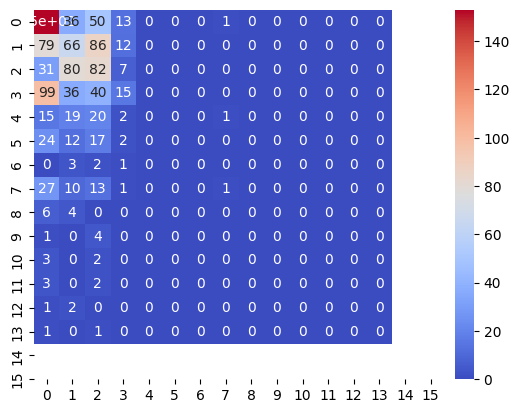

In [181]:
# Create the KNeighborsClassifier and fit the model 
knc = KNeighborsClassifier(n_neighbors=19)
knc.fit(X_train, y_train)

# Predict
knc_pred = knc.predict(X_test)

# Evaluate accuracy
cm = confusion_matrix(y_test, knc_pred)
sns.heatmap(cm, annot=True, cmap='coolwarm',
            xticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'],
            yticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])
print(classification_report(y_test, knc_pred))

This KNeighborsClassifier predicts the demographic of the company with an accuracy of 0.29.

# V. Accreditation Status Predictions

I am building 2 models from 2 different datasets to predict a business's accreditation.

## 1) Approach from the MainBusinessData dataset

In [6]:
# Select only rows from businesses that are based in GA
df_MainBusinessData_full = df_MainBusinessData_full[df_MainBusinessData_full['State Established'] == 'GA']

# Drop columns containing data that is not useful for analysis
for var in ['Address 2', 'City', 'State', 'Country', 'County', 'Region', 'Address', 'State Established', 'Business ID', 'Business']:
    df_MainBusinessData_full = df_MainBusinessData_full.drop(columns=[var])

# Drop empty rows
for var in ['AB?', 'Established', 'TOB', 'Zip', 'Rating', 'Annual Revenue', 'Employees']:
    df_MainBusinessData_full = df_MainBusinessData_full.dropna(subset=[var])

# Re-classify 'URL', 'Facebook', and 'Email' columns as boolean
for var in ['URL', 'Facebook', 'Email']:
    df_MainBusinessData_full[var] = df_MainBusinessData_full[var].fillna(0).astype(bool).astype(int)

# Modify 'AB?' column into 1s and 0s
df_MainBusinessData_full['AB?'] = df_MainBusinessData_full['AB?'].astype(int)

# Modify these columns into "Category"
for var in ['Zip', 'TOB', 'Rating']:
    df_MainBusinessData_full[var] = df_MainBusinessData_full[var].astype('category')

# Convert Date Established to Year Established
df_MainBusinessData_full['Established'] = pd.to_datetime(df_MainBusinessData_full['Established'])
df_MainBusinessData_full['Established'] = df_MainBusinessData_full['Established'].dt.year

# View data type for dataframe
df_MainBusinessData_full.dtypes

AB?                  int64
Established          int32
TOB               category
Zip               category
Rating            category
Annual Revenue     float64
Employees            int64
URL                  int64
Facebook             int64
Email                int64
dtype: object

In [7]:
# Create dummy variables for categorical data
df_dummy = pd.get_dummies(
    data=df_MainBusinessData_full,
    drop_first=True,
    dtype='int64'
)

# Inspect dummy variable
df_dummy

AB?  Established  Annual Revenue  Employees  URL  Facebook  Email  \
2         0         2017         50000.0          1    1         0      1   
6         0         2010         85820.0          1    1         0      1   
7         0         2012             0.0          1    1         0      1   
13        0         2016        200000.0          1    1         0      1   
14        0         2016        180000.0          1    1         1      1   
...     ...          ...             ...        ...  ...       ...    ...   
150872    0         2010       2500000.0          5    1         0      1   
150875    0         1996        800000.0          8    1         0      1   
150876    0         1986        390000.0         26    1         1      1   
150882    1         2013       1000000.0          4    1         1      1   
150886    0         2004       1000000.0          1    1         0      1   

        TOB_Above Ground Pools  TOB_Abrasives  TOB_Access Control Systems  \
2                            0              0                           0   
6                            0              0                           0   
7                            0              0                           0   
13                           0              0                           0   
14                           0              0                           0   
...                        ...            ...                         ...   
150872                       0              0                           0   
150875                       0              0                           0   
150876                       0              0                           0   
150882                       0              0                           0   
150886                       0              0                           0   

        TOB_Accessories  TOB_Accident Insurance  TOB_Accident Reconstruction  \
2                     0                       0                            0   
6                     0                       0                            0   
7                     0                       0                            0   
13                    0                       0                            0   
14                    0                       0                            0   
...                 ...                     ...                          ...   
150872                0                       0                            0   
150875                0                       0                            0   
150876                0                       0                            0   
150882                0                       0                            0   
150886                0                       0                            0   

        TOB_Accountant  TOB_Accounting  TOB_Acoustic Material  \
2                    0               0                      0   
6                    0               0                      0   
7                    0               0                      0   
13                   0               0                      0   
14                   0               0                      0   
...                ...             ...                    ...   
150872               0               0                      0   
150875               0               0                      0   
150876               0               0                      0   
150882               0               0                      0   
150886               0               0                      0   

        TOB_Acoustical Ceiling Contractors  TOB_Acoustical Consultant  \
2                                        0                          0   
6                                        0                          0   
7                                        0                          0   
13                                       0                          0   
14                                       0         

In [8]:
# Define features and target variable for analysis
X = df_dummy.drop(columns = ['AB?'])
Y = df_dummy['AB?']

In [9]:
# Split the data set into training and testing data, stratifying cross validation to limit overfitting
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [ ]:
# Keep track of performance
rmse_test = []
rmse_train = []
n_neighbors = []

# Fit the model and get mode process
for n in range(1,20): 
    n_neighbors.append(n)
    # Step 2: Create and fit the model 
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(X_train, Y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate model performance
    rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
    rmse_test.append(rmse)

    # keep track of train set performance
    y_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(Y_train, y_pred))
    rmse_train.append(rmse)

# Find the index of the minimum test RMSE
min_rmse_index = np.argmin(rmse_test)

# Optimal number of nearest neighbors
optimal_n_neighbors = n_neighbors[min_rmse_index]

# Minimum test RMSE
min_test_rmse = rmse_test[min_rmse_index]

print("Optimal number of nearest neighbors:", optimal_n_neighbors)

In [11]:
################################### kNN #########################################

# Create a pipeline for kNN classifier
pipe = Pipeline([
        ('sc', MinMaxScaler(feature_range=(0, 1))), # Normalize Data to 0~1
        ('knn', KNeighborsClassifier(p=2, metric='minkowski', n_neighbors=19)) # kNN Classifier with specified parameters
      ])

# Fit the pipeline to the training data
pipe.fit(X_train,Y_train)

# Evaluate the kNN classifier using 10-fold cross-validation
knn_original_score = cross_val_score(pipe, X_train, 
                                     Y_train, cv = 10, 
                                     scoring = "f1")  # Evaluate model performance using f1 score
print("kNN f1: %0.2f (+/- %0.2f)" % (knn_original_score.mean(), knn_original_score.std()))

################################### Decision Tree ################################

# Evaluate the Decision Tree classifier using 10-fold cross-validation
dt_original_score = cross_val_score(DecisionTreeClassifier(max_depth = 10),
                                    X_train,
                                    Y_train,
                                    cv=10,
                                    scoring="f1")
print("Decision Tree f1: %0.2f (+/- %0.2f)" % (dt_original_score.mean(), dt_original_score.std()))

################################### Logistic Regression ################################

# Evaluate the Logistic Regression classifier using 10-fold cross-validation
logistic_original_score = cross_val_score(LogisticRegression(),
                                          X_train,
                                          Y_train,
                                          cv=10,
                                          scoring="f1")
print("Logistic Regression f1: %0.2f (+/- %0.2f)" % (logistic_original_score.mean(), logistic_original_score.std()))

kNN f1: 0.35 (+/- 0.03)
Decision Tree f1: 0.35 (+/- 0.05)
Logistic Regression f1: 0.00 (+/- 0.00)


KNN Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19990
           1       1.00      1.00      1.00      4818

    accuracy                           1.00     24808
   macro avg       1.00      1.00      1.00     24808
weighted avg       1.00      1.00      1.00     24808

KNN Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      8567
           1       0.47      0.18      0.26      2065

    accuracy                           0.80     10632
   macro avg       0.65      0.56      0.57     10632
weighted avg       0.76      0.80      0.76     10632

Decision Tree Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19990
           1       1.00      0.98      0.99      4818

    accuracy                           1.00     24808
  

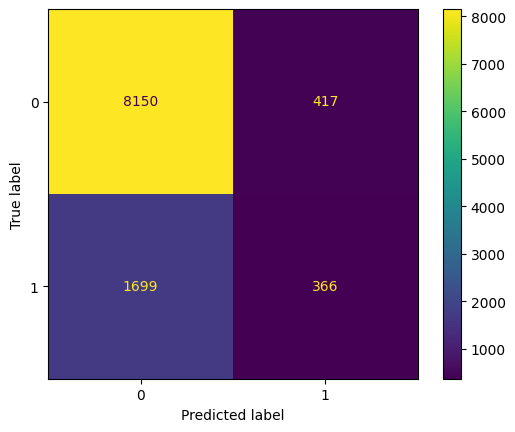

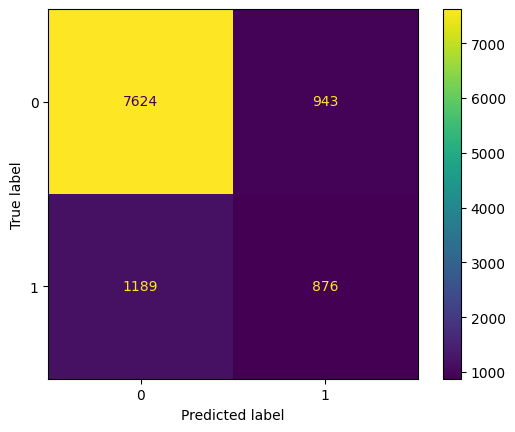

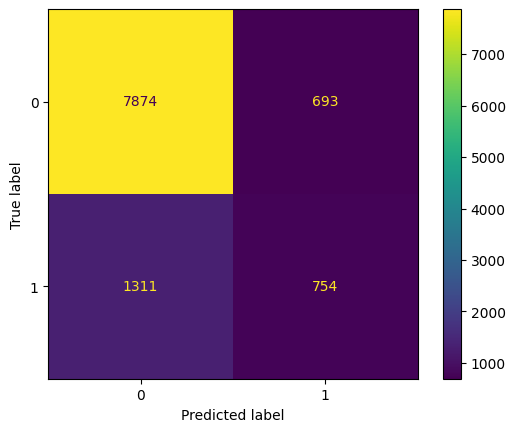

In [12]:
################################### kNN #########################################

# Define the kNN pipeline
pipeknn = Pipeline([
        ('sc', StandardScaler()), # Standardize all features
        ('knn', KNeighborsClassifier(n_neighbors=19,
                                    p=2,                 
                                    metric='minkowski', 
                                    n_jobs=-1,
                                    weights='distance')) 
                  ]) # kNN with specified parameters

# Fit the kNN pipeline to the training data
knn = pipeknn.fit(X_train, Y_train)

# Make predictions and probability estimates for the kNN model
predprobKnn = knn.predict_proba(X_test)
predTrainKnn = knn.predict(X_train)
predTestKnn = knn.predict(X_test)

# Print classification reports for kNN model
print("KNN Training Set Classification Report:")
print(sklearn.metrics.classification_report(Y_train, predTrainKnn))
print("KNN Test Set Classification Report:")
print(sklearn.metrics.classification_report(Y_test, predTestKnn))

# Generate confusion matrix plot for kNN model
cmKnn = sklearn.metrics.confusion_matrix(Y_test, predTestKnn)
plotCmKnn = sklearn.metrics.ConfusionMatrixDisplay( cmKnn, display_labels=knn.classes_ ).plot()

################################### Decision Tree ################################

# Define the Decision Tree classifier
trees = DecisionTreeClassifier(random_state=42,
                               min_samples_leaf = 1, 
                               min_samples_split = 3,
                               criterion = 'entropy')

# Fit the Decision Tree classifier to the training data
tree = trees.fit(X_train, Y_train)

# Make predictions and probability estimates for the Decision Tree model
predprobTrees = tree.predict_proba(X_test)
predTrainTree = tree.predict(X_train)
predTestTree = tree.predict(X_test)

# Print classification reports for Decision Tree model
print("Decision Tree Training Set Classification Report:")
print(sklearn.metrics.classification_report(Y_train, predTrainTree))
print("Decision Tree Test Set Classification Report:")
print(sklearn.metrics.classification_report(Y_test, predTestTree))

# Generate confusion matrix plot for Decision Tree model
cmTree = sklearn.metrics.confusion_matrix(Y_test, predTestTree)
plotCmTree = sklearn.metrics.ConfusionMatrixDisplay(cmTree, display_labels=tree.classes_).plot()

################################## Logistic Regression ###########################

# Define the Logistic Regression pipeline
pipeLogistic = Pipeline([
                ('sc', StandardScaler()), # Standardize the features
                ('logit', LogisticRegression(penalty='l2', C = 1000 , solver='liblinear')) # Logistic Regression Classifier with specified parameters
                        ])

# Fit the Logistic Regression pipeline to the training data
logit = pipeLogistic.fit(X_train, Y_train)

# Make predictions and probability estimates for the Logistic Regression model
predprobLogistic = logit.predict_proba(X_test)
predTrainLogistic = logit.predict(X_train)
predTestLogistic = logit.predict(X_test)

# Print classification reports for Logistic Regression model
print("Logistic Regression Training Set Classification Report:")
print(sklearn.metrics.classification_report(Y_train, predTrainLogistic))
print("Logistic Regression Test Set Classification Report:")
print(sklearn.metrics.classification_report(Y_test, predTestLogistic))

# Generate confusion matrix plot for Logistic Regression model
cmLogistic = sklearn.metrics.confusion_matrix(Y_test, predTestLogistic)
plotCmLogistic = sklearn.metrics.ConfusionMatrixDisplay(cmLogistic, display_labels=logit.classes_).plot()

In [13]:
# Access the coefficients of the logistic regression model
coefficients = logit.named_steps['logit'].coef_

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame to display the coefficients along with feature names
coefficients_df = pd.DataFrame(coefficients, columns=feature_names)
print(coefficients_df)

   Established  Annual Revenue  Employees       URL  Facebook     Email  \
0     0.041797        0.390387   0.034686  0.452958  0.585399  0.838831   

   TOB_Above Ground Pools  TOB_Abrasives  TOB_Access Control Systems  \
0                     0.0      -0.032727                    0.034253   

   TOB_Accessories  TOB_Accident Insurance  TOB_Accident Reconstruction  \
0        -0.088989                 0.03021                          0.0   

   TOB_Accountant  TOB_Accounting  TOB_Acoustic Material  \
0        0.012841        0.096398              -0.060477   

   TOB_Acoustical Ceiling Contractors  TOB_Acoustical Consultant  \
0                           -0.059203                        0.0   

   TOB_Acting Classes  TOB_Activated Carbon  TOB_Actuary  TOB_Acupuncturist  \
0           -0.121921                   0.0     0.033501          -0.085818   

   TOB_Adhesive  TOB_Adhesives and Gluing Equipment  TOB_Adjuster  \
0     -0.060772                                 0.0     -0.080061  

10-fold cross validation:

ROC AUC: 0.75 (+/- 0.02) [Logistic regression]
ROC AUC: 0.65 (+/- 0.01) [Decision tree]
ROC AUC: 0.61 (+/- 0.02) [kNN]


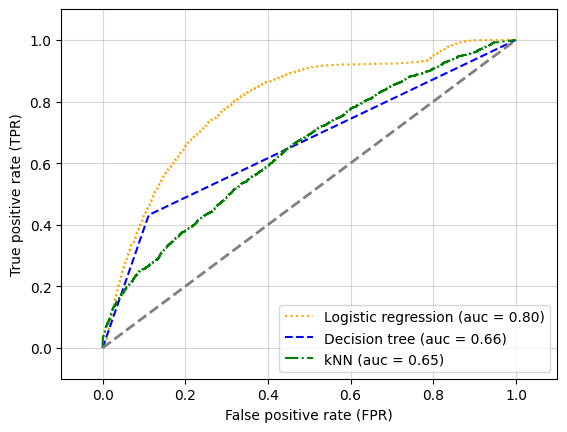

In [192]:
# Define classifiers and labels
clf_labels = ['Logistic regression', 'Decision tree', 'kNN']
all_clf = [logit, tree, knn]

# Perform 10-fold cross-validation for each classifier
print('10-fold cross validation:\n')
for clf, label in zip([logit, trees, pipeknn], clf_labels): #For all classifiers
    # Calculate ROC AUC scores using cross-validation
    scores = cross_val_score(estimator=clf,
                             X=X_test,
                             y=Y_test,
                             cv=10,
                             scoring='roc_auc')
    # Print mean ROC AUC score and its standard deviation for performance analysis
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

##################################### Visualization ######################################

colors = [ 'orange', 'blue', 'green']      # colors for visualization
linestyles = [':', '--', '-.', '-']        # line styles for visualization
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # Make predictions and calculate ROC curve, assuming the label of the positive class is 1 and data is normalized
    y_pred = clf.fit(X_train, Y_train).predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_true=Y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr) # compute Area Under the Curve (AUC)
    # Plot ROC curve for each classifier
    plt.plot(fpr, tpr,                                
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

# Plot the random guess line
plt.plot([0, 1], [0, 1],        
         linestyle='--',     
         color='gray',
         linewidth=2)

# Set plot limits, labels, and legend
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.legend(loc='lower right')
plt.show()

## 2) Approach from the Demographic Dataset

In [193]:
for var in ['Zip', 'TOB', 'Rating']:
    df_merged[var] = df_merged[var].astype('category')

df_merged.dtypes

AB?                  int64
Established          int32
TOB               category
Zip               category
Rating            category
Annual Revenue     float64
Employees          float64
URL                  int64
Facebook             int64
Email                int64
Demographic          int64
Median HHI           int64
Mean HHI             int64
dtype: object

In [194]:
# Create dummy variables for categorical data
df_dummy = pd.get_dummies(
    data=df_merged,
    drop_first=True,
    dtype='int64'
)

# Inspect dummy variables
df_dummy = df_dummy.dropna()

In [195]:
Y = df_dummy['AB?']
X = df_dummy.drop(columns='AB?')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [196]:
# Keep track of performance
rmse_test = []
rmse_train = []
n_neighbors = []

# Fit the model and get mode process
for n in range(1,20): 
    n_neighbors.append(n)
    # Step 2: Create and fit the model 
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(X_train, Y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate model performance
    rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
    rmse_test.append(rmse)

    # keep track of train set performance
    y_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(Y_train, y_pred))
    rmse_train.append(rmse)

# Find the index of the minimum test RMSE
min_rmse_index = np.argmin(rmse_test)

# Optimal number of nearest neighbors
optimal_n_neighbors = n_neighbors[min_rmse_index]

# Minimum test RMSE
min_test_rmse = rmse_test[min_rmse_index]

print("Optimal number of nearest neighbors:", optimal_n_neighbors)

Optimal number of nearest neighbors: 2


In [197]:
################################### kNN #########################################

# Create a pipeline for kNN classifier
pipe = Pipeline([
        ('sc', MinMaxScaler(feature_range=(0, 1))), # Normalize Data to 0~1
        ('knn', KNeighborsClassifier(p=2, metric='minkowski', n_neighbors=19)) # kNN Classifier with specified parameters
      ])

# Fit the pipeline to the training data
pipe.fit(X_train,Y_train)

# Evaluate the kNN classifier using 10-fold cross-validation
knn_original_score = cross_val_score(pipe, X_train, 
                                     Y_train, cv = 10, 
                                     scoring = "f1")  # Evaluate model performance using f1 score
print("kNN f1: %0.2f (+/- %0.2f)" % (knn_original_score.mean(), knn_original_score.std()))

################################### Decision Tree ################################

# Evaluate the Decision Tree classifier using 10-fold cross-validation
dt_original_score = cross_val_score(DecisionTreeClassifier(max_depth = 10),
                                    X_train,
                                    Y_train,
                                    cv=10,
                                    scoring="f1")
print("Decision Tree f1: %0.2f (+/- %0.2f)" % (dt_original_score.mean(), dt_original_score.std()))

################################### Logistic Regression ################################

# Evaluate the Logistic Regression classifier using 10-fold cross-validation
logistic_original_score = cross_val_score(LogisticRegression(),
                                          X_train,
                                          Y_train,
                                          cv=10,
                                          scoring="f1")
print("Logistic Regression f1: %0.2f (+/- %0.2f)" % (logistic_original_score.mean(), logistic_original_score.std()))

kNN f1: 0.91 (+/- 0.01)
Decision Tree f1: 0.92 (+/- 0.01)
Logistic Regression f1: 0.91 (+/- 0.00)


KNN Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       391
           1       1.00      1.00      1.00      1912

    accuracy                           1.00      2303
   macro avg       1.00      1.00      1.00      2303
weighted avg       1.00      1.00      1.00      2303

KNN Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.44      0.60       168
           1       0.90      1.00      0.94       819

    accuracy                           0.90       987
   macro avg       0.92      0.72      0.77       987
weighted avg       0.91      0.90      0.89       987

Decision Tree Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       391
           1       1.00      0.99      1.00      1912

    accuracy                           1.00      2303
  

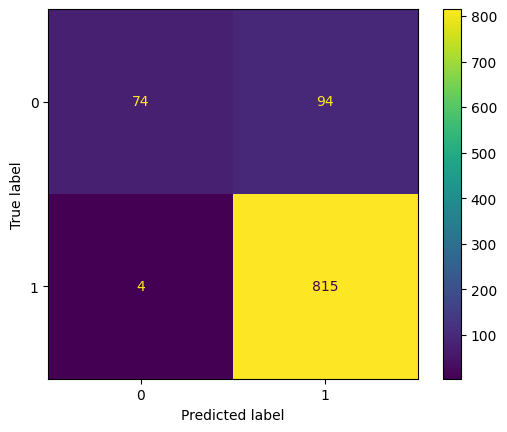

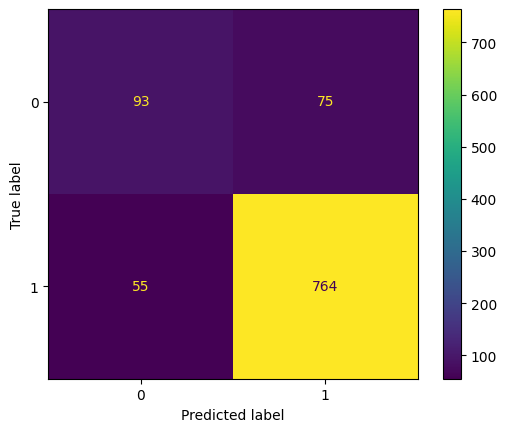

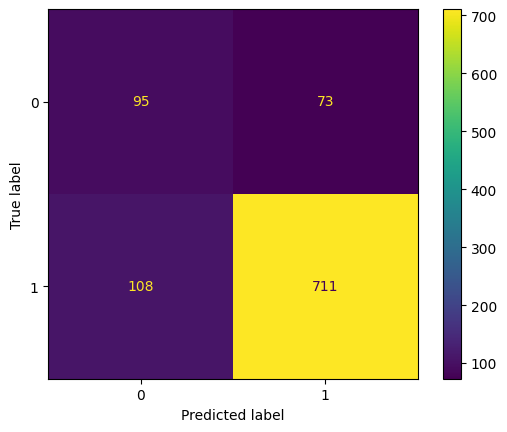

In [198]:
################################### kNN #########################################

# Define the kNN pipeline
pipeknn = Pipeline([
        ('sc', StandardScaler()), # Standardize all features
        ('knn', KNeighborsClassifier(n_neighbors=19,
                                    p=2,                 
                                    metric='minkowski', 
                                    n_jobs=-1,
                                    weights='distance')) 
                  ]) # kNN with specified parameters

# Fit the kNN pipeline to the training data
knn = pipeknn.fit(X_train, Y_train)

# Make predictions and probability estimates for the kNN model
predprobKnn = knn.predict_proba(X_test)
predTrainKnn = knn.predict(X_train)
predTestKnn = knn.predict(X_test)

# Print classification reports for kNN model
print("KNN Training Set Classification Report:")
print(sklearn.metrics.classification_report(Y_train, predTrainKnn))
print("KNN Test Set Classification Report:")
print(sklearn.metrics.classification_report(Y_test, predTestKnn))

# Generate confusion matrix plot for kNN model
cmKnn = sklearn.metrics.confusion_matrix(Y_test, predTestKnn)
plotCmKnn = sklearn.metrics.ConfusionMatrixDisplay( cmKnn, display_labels=knn.classes_ ).plot()

################################### Decision Tree ################################

# Define the Decision Tree classifier
trees = DecisionTreeClassifier(random_state=42,
                               min_samples_leaf = 1, 
                               min_samples_split = 3,
                               criterion = 'entropy')

# Fit the Decision Tree classifier to the training data
tree = trees.fit(X_train, Y_train)

# Make predictions and probability estimates for the Decision Tree model
predprobTrees = tree.predict_proba(X_test)
predTrainTree = tree.predict(X_train)
predTestTree = tree.predict(X_test)

# Print classification reports for Decision Tree model
print("Decision Tree Training Set Classification Report:")
print(sklearn.metrics.classification_report(Y_train, predTrainTree))
print("Decision Tree Test Set Classification Report:")
print(sklearn.metrics.classification_report(Y_test, predTestTree))

# Generate confusion matrix plot for Decision Tree model
cmTree = sklearn.metrics.confusion_matrix(Y_test, predTestTree)
plotCmTree = sklearn.metrics.ConfusionMatrixDisplay(cmTree, display_labels=tree.classes_).plot()

################################## Logistic Regression ###########################

# Define the Logistic Regression pipeline
pipeLogistic = Pipeline([
                ('sc', StandardScaler()), # Standardize the features
                ('logit', LogisticRegression(penalty='l2', C = 1000 , solver='liblinear')) # Logistic Regression Classifier with specified parameters
                        ])

# Fit the Logistic Regression pipeline to the training data
logit = pipeLogistic.fit(X_train, Y_train)

# Make predictions and probability estimates for the Logistic Regression model
predprobLogistic = logit.predict_proba(X_test)
predTrainLogistic = logit.predict(X_train)
predTestLogistic = logit.predict(X_test)

# Print classification reports for Logistic Regression model
print("Logistic Regression Training Set Classification Report:")
print(sklearn.metrics.classification_report(Y_train, predTrainLogistic))
print("Logistic Regression Test Set Classification Report:")
print(sklearn.metrics.classification_report(Y_test, predTestLogistic))

# Generate confusion matrix plot for Logistic Regression model
cmLogistic = sklearn.metrics.confusion_matrix(Y_test, predTestLogistic)
plotCmLogistic = sklearn.metrics.ConfusionMatrixDisplay(cmLogistic, display_labels=logit.classes_).plot()

10-fold cross validation:

ROC AUC: 0.62 (+/- 0.08) [Logistic regression]
ROC AUC: 0.66 (+/- 0.06) [Decision tree]
ROC AUC: 0.70 (+/- 0.05) [kNN]


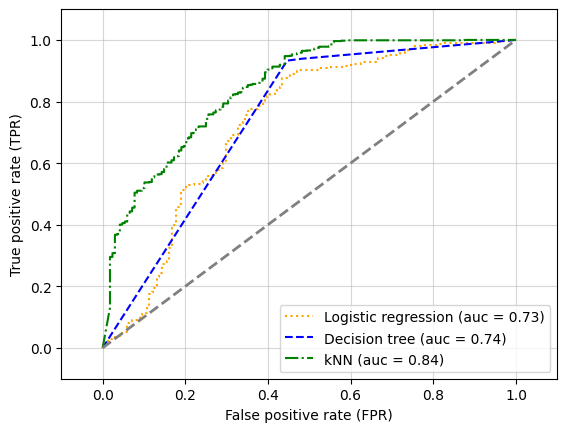

In [199]:
# Define classifiers and labels
clf_labels = ['Logistic regression', 'Decision tree', 'kNN']
all_clf = [logit, tree, knn]

# Perform 10-fold cross-validation for each classifier
print('10-fold cross validation:\n')
for clf, label in zip([logit, trees, pipeknn], clf_labels): #For all classifiers
    # Calculate ROC AUC scores using cross-validation
    scores = cross_val_score(estimator=clf,
                             X=X_test,
                             y=Y_test,
                             cv=10,
                             scoring='roc_auc')
    # Print mean ROC AUC score and its standard deviation for performance analysis
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

##################################### Visualization ######################################

colors = [ 'orange', 'blue', 'green']      # colors for visualization
linestyles = [':', '--', '-.', '-']        # line styles for visualization
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # Make predictions and calculate ROC curve, assuming the label of the positive class is 1 and data is normalized
    y_pred = clf.fit(X_train, Y_train).predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_true=Y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr) # compute Area Under the Curve (AUC)
    # Plot ROC curve for each classifier
    plt.plot(fpr, tpr,                                
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

# Plot the random guess line
plt.plot([0, 1], [0, 1],        
         linestyle='--',     
         color='gray',
         linewidth=2)

# Set plot limits, labels, and legend
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.legend(loc='lower right')
plt.show()